In [401]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as si
import seaborn as sns

In [402]:
### parameters 
S0 = 100
K = 98
T = [0,0.25,0.5,0.75,1]
r = .0
delta = 0.02
mcpath = 100000
n = len(T)
np.random.seed(420) 

## PART A

In [403]:
n = len(T) # number of periods
sigma = 0.23 # Constant sigma 
dt = 1/4 # Constat time interval
S = np.zeros((mcpath,n)) 
for i in range(0,mcpath):
    t = 0 
    W = 0 
    C=np.ones(5)
    for j in range(0,n):
        if j==0:
            C[j]=100
        else:
            W = np.random.normal(0,np.sqrt(dt))
            C[j]=np.exp((r-delta-0.5*sigma**2)*dt+sigma*W)
        S[i,j] = np.prod(C) # price path

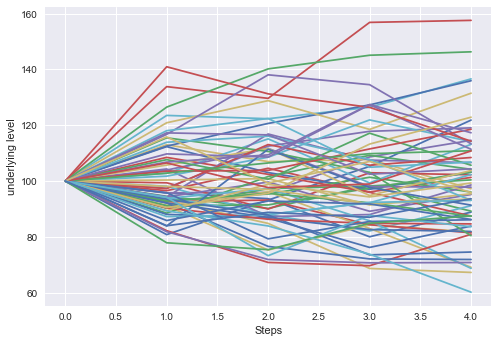

In [380]:
sdff=pd.DataFrame(S)
import matplotlib.pyplot as plt

plt.style.use('seaborn')

plt.plot(sdff.T.loc[:,0:1000:15])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('underlying level')
plt.show()

In [381]:
# Compute A for t1 t2 t3 t3
A = np.zeros((mcpath,n))
A[:,1] = S[:,1]
A[:,2] = (S[:,1] + S[:,2])/2
A[:,3] = (S[:,1] + S[:,2] + S[:,3])/3
A[:,4] = (S[:,1] + S[:,2] + S[:,3] + S[:,4])/4

In [382]:
## define function for the intrinsic value
def intr(a):
    res = np.array([])
    for k in range(0,len(a)):
        if a[k] > 0:
            res = np.append(res,a[k]) 
        else:
            res = np.append(res,0)
    return res

In [404]:
 C = np.zeros((mcpath,n))
C[:,n-1] = intr(A[:,n-1]-K) # intrinsic value at the last period
for i in range(1,n):
    X = np.array([np.ones(mcpath),S[:,n-1-i],S[:,n-1-i]**2,S[:,n-1-i]**3,A[:,n-1-i],A[:,n-1-i]**2,A[:,n-1-i]**3]).T # variables on which 
    Y = np.sum(C,axis = 1) # cashflows received if not exercised 
    beta = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,Y)) # beta coefficients 
    Y_reg = np.dot(X,beta) # continuation value
    stop = intr(A[:,n-1-i]-K) > Y_reg # determing optimal stopping points
    C[:,n-1-i] = intr(A[:,n-1-i]-K)*stop # assign optimal stopping values to the cash flows
    for j in range(0,mcpath):
        if (stop[j] == True):  
            if (C[j,n-i-1] > 0):
                C[j,n-i:n] = 0 # delate cashflows after optimal strike
  

In [405]:
 g=pd.DataFrame(C, columns=T).astype(bool).sum(axis=0)/mcpath #when optimal 

In [406]:
g

0.00    0.00000
0.25    0.22083
0.50    0.07255
0.75    0.04290
1.00    0.17726
dtype: float64

In [407]:
sum(sum(C.T))/mcpath # price using LSMC with constant volatility.

6.264046281932168

In [408]:
dff=pd.DataFrame(sum(C.T))
dff.describe()# summary statistic of the LSMC

,0
count,100000.000000
mean,6.264046
std,8.246201
min,0.000000
25%,0.000000
50%,0.656099
75%,11.694952
max,97.799473


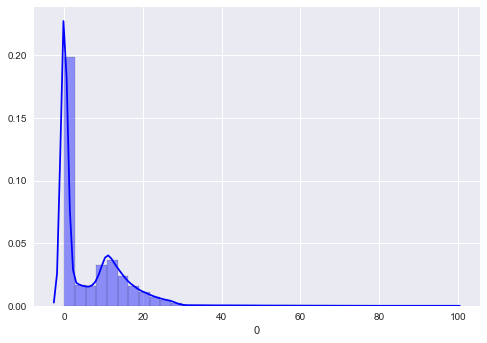

In [409]:
sns.distplot(dff[0], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [410]:
## BSM price of an European Call which is the lower boundary of the price of an american       call
def bs(S, K, T, r, q, sigma):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call 
bs(S0, K, 1,r,delta, sigma)

8.983224650185882

## point b

In [411]:
## import implied volatilites from problem set 5
ind= pd.read_csv('/Users/francescomaizza/Documents/GitHub/advanced_derivatives/problem_set_7/strikes.csv',names=['s'])/2772.70 
mat=pd.read_csv('/Users/francescomaizza/Documents/GitHub/advanced_derivatives/problem_set_7/maturities.csv')
v=list(mat.columns)
vol= pd.read_csv('/Users/francescomaizza/Documents/GitHub/advanced_derivatives/problem_set_7/impv_total.csv',names=v)
vol.index=ind.s

In [412]:
localvol=vol.loc[K/S0] # get the implied volatiliets for our K/S0
localvol=pd.concat([pd.Series([0]), localvol])

In [413]:
localvol=localvol.iloc[0:localvol.index.get_loc('1')+1] # consider volatility upto T=1

In [414]:
xp=[float(i) for i in localvol.index]
d=np.arange(0, 13, 1)/12
d=d.tolist()
localvolint=np.interp(d, xp, localvol) #interpolate local volatilities so to have montlhy                                          periods

In [415]:
n=len(localvolint) 
S = np.zeros((mcpath,n))
for i in range(0,mcpath):
    t = 0 
    W = 0 
    C=np.ones(n)
    j=0
    dt=1/12
    for j in range(0,n):
        if j==0:
            C[j]=100
        else:
            W = np.random.normal(0,np.sqrt(dt))
            C[j]=np.exp((r-delta-0.5*localvolint[j]**2)*dt+localvolint[j]*W)
        S[i,j] = np.prod(C)

In [416]:
sdf=pd.DataFrame(S)
A = np.zeros((mcpath,n))
for i in range(1,n):
    col = sdf.loc[: , 1:i]
    A[:,i] = col.mean(axis=1)

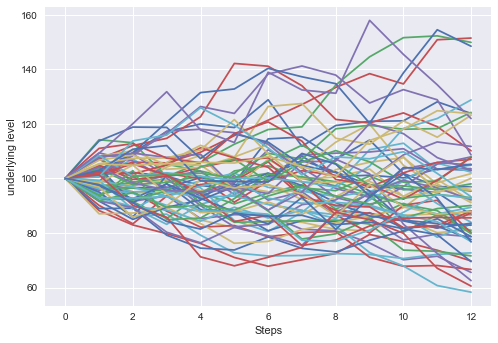

In [417]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

 
plt.plot(sdf.T.loc[:,0:1000:15])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('underlying level')
plt.show()

In [418]:
C = np.zeros((mcpath,n))# always possible to exercise in 5 periods
C[:,n-1] = intr(A[:,n-1]-K) # intrinsic value at the last period
for i in range(1,5):
    X = np.array([np.ones(mcpath),S[:,n-1-3*i],S[:,n-1-3*i]**2,S[:,n-1-3*i]**3,A[:,n-1-3*i],A[:,n-1-3*i]**2,A[:,n-1-3*i]**3]).T # variables on which 
    Y = np.sum(C,axis = 1) # cashflows received if not exercised 
    beta = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,Y)) # beta coefficients 
    Y_reg = np.dot(X,beta) # continuation value
    stop = intr(A[:,n-1-3*i]-K) > Y_reg # determing optimal stopping points
    C[:,n-1-3*i] = intr(A[:,n-1-3*i]-K)*stop # assign optimal stopping values to the cash flows
    if (stop[j] == True):  
            if (C[j,n-1-3*i] > 0):
                C[j,n-i:n] = 0 # delate cashflows after optimal strike
                


In [419]:
price = sum(sum(C.T))/mcpath
price

8.69984692813612

In [420]:
pd.DataFrame(C).astype(bool).sum(axis=0)/mcpath


0     0.00000
1     0.00000
2     0.00000
3     0.02043
4     0.00000
5     0.00000
6     0.01742
7     0.00000
8     0.00000
9     0.19628
10    0.00000
11    0.00000
12    0.49415
dtype: float64

In [421]:
df=pd.DataFrame(sum(C.T))
df.describe()

,0
count,100000.000000
mean,8.699847
std,12.700737
min,0.000000
25%,0.000000
50%,0.936380
75%,14.380725
max,226.592400


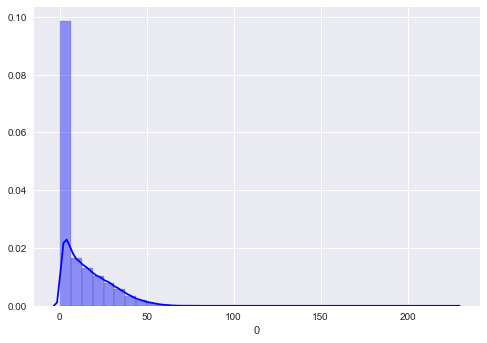

In [422]:
sns.distplot(df[0], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})